## Bayesian Neural Network (cc exg ch cv)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline

### load data

In [41]:
with open("./data/train_data/grid_cc.npy", "rb") as fin:
    x_train_grid_cc = np.load(fin)

with open("./data/train_data/grid_exg.npy", "rb") as fin:
    x_train_grid_exg = np.load(fin)
    
with open("./data/train_data/grid_ch.npy", "rb") as fin:
    x_train_grid_ch = np.load(fin)
    
with open("./data/train_data/grid_cv.npy", "rb") as fin:
    x_train_grid_cv = np.load(fin)
    
with open("./data/train_data/yield_train.npy", "rb") as fin:
    y_train = np.load(fin)

In [42]:
print(x_train_grid_cc.shape)
print(x_train_grid_exg.shape)
print(x_train_grid_ch.shape)
print(x_train_grid_cv.shape)
print(y_train.shape)

(7240, 120)
(7240, 120)
(7240, 120)
(7240, 120)
(7240, 1)


In [43]:
with open("./data/test_data/grid_cc.npy", "rb") as fin:
    x_testset_cc = np.load(fin)

with open("./data/test_data/grid_exg.npy", "rb") as fin:
    x_testset_exg = np.load(fin)
    
with open("./data/test_data/grid_ch.npy", "rb") as fin:
    x_testset_ch = np.load(fin)
    
with open("./data/test_data/grid_cv.npy", "rb") as fin:
    x_testset_cv = np.load(fin)
    
with open("./data/test_data/yield_test.npy", "rb") as fin:
    y_testset = np.load(fin)

In [44]:
print(x_testset_cc.shape)
print(x_testset_exg.shape)
print(x_testset_ch.shape)
print(x_testset_cv.shape)
print(y_testset.shape)

(3983, 120)
(3983, 120)
(3983, 120)
(3983, 120)
(3983, 1)


#### yield kg/(100m2) => kg/ha

In [45]:
y_train = y_train / 0.01
y_testset = y_testset / 0.01

### train, validation, and test

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
def split_train_test(x, y, test_size=0.3):
    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=test_size, random_state=42
    )
    x_valid, x_test, y_valid, y_test = train_test_split(
        x_valid, y_valid, test_size=0.5, random_state=43
    )
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [48]:
x_train_grid_cc, x_valid_grid_cc, x_test_grid_cc, y_train_grid_cc, y_valid_grid_cc, y_test_grid_cc = split_train_test(x_train_grid_cc, y_train)

In [49]:
x_train_grid_exg, x_valid_grid_exg, x_test_grid_exg, y_train_grid_exg, y_valid_grid_exg, y_test_grid_exg = split_train_test(x_train_grid_exg, y_train)

In [50]:
x_train_grid_ch, x_valid_grid_ch, x_test_grid_ch, y_train_grid_ch, y_valid_grid_ch, y_test_grid_ch = split_train_test(x_train_grid_ch, y_train)

In [51]:
x_train_grid_cv, x_valid_grid_cv, x_test_grid_cv, y_train_grid_cv, y_valid_grid_cv, y_test_grid_cv = split_train_test(x_train_grid_cv, y_train)

In [52]:
all(y_train_grid_cc == y_train_grid_exg), all(y_train_grid_exg == y_train_grid_ch), all(y_train_grid_ch == y_train_grid_cv)

(True, True, True)

In [53]:
all(y_valid_grid_cc == y_valid_grid_exg), all(y_valid_grid_exg == y_valid_grid_ch), all(y_valid_grid_ch == y_valid_grid_cv)

(True, True, True)

In [54]:
all(y_test_grid_cc == y_test_grid_exg), all(y_test_grid_exg == y_test_grid_ch), all(y_test_grid_ch == y_test_grid_cv)

(True, True, True)

In [55]:
y_train = y_train_grid_cc
y_valid = y_valid_grid_cc
y_test = y_test_grid_cc

#### metrics

In [56]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#### cc, exg, ch, cv

In [57]:
x_train_cxhv = np.concatenate(
    [x_train_grid_cc, x_train_grid_exg, x_train_grid_cv],
    axis=1,
)

x_train_cxhv.shape, y_train.shape

((5068, 360), (5068, 1))

In [58]:
x_valid_cxhv = np.concatenate(
    [x_valid_grid_cc, x_valid_grid_exg, x_valid_grid_cv],
    axis=1,
)

x_valid_cxhv.shape, y_valid.shape

((1086, 360), (1086, 1))

In [59]:
x_test_cxhv = np.concatenate(
    [x_test_grid_cc, x_test_grid_exg, x_test_grid_cv],
    axis=1,
)

x_test_cxhv.shape, y_test.shape

((1086, 360), (1086, 1))

In [60]:
x_testset_cxhv = np.concatenate(
    [x_testset_cc, x_testset_exg, x_testset_ch],
    axis=1,
)

x_testset_cxhv.shape, y_testset.shape

((3983, 360), (3983, 1))

### BNN

In [23]:
import torch
import torch.nn as nn

In [24]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.nn import PyroModule, PyroSample

In [25]:
x_train_cxhv = torch.from_numpy(x_train_cxhv).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)

In [26]:
class BNN(PyroModule):
    def __init__(self, in_features, out_features):
        super(BNN, self).__init__()
        self.linear_1 = PyroModule[nn.Linear](in_features, 512)
        self.linear_1.weight = PyroSample(
            dist.Normal(0.0, 1.0).expand([512, in_features]).to_event(2)
        )
        self.linear_1.bias = PyroSample(dist.Normal(0.0, 1.0).expand([512]).to_event(1))

        self.linear_2 = PyroModule[nn.Linear](512, 1024)
        self.linear_2.weight = PyroSample(
            dist.Normal(0.0, 1.0).expand([1024, 512]).to_event(2)
        )
        self.linear_2.bias = PyroSample(
            dist.Normal(0.0, 1.0).expand([1024]).to_event(1)
        )

        self.linear_3 = PyroModule[nn.Linear](1024, 256)
        self.linear_3.weight = PyroSample(
            dist.Normal(0.0, 1.0).expand([256, 1024]).to_event(2)
        )
        self.linear_3.bias = PyroSample(dist.Normal(0.0, 1.0).expand([256]).to_event(1))

        self.linear_4 = PyroModule[nn.Linear](256, 1)
        self.linear_4.weight = PyroSample(
            dist.Normal(0.0, 1.0).expand([1, 256]).to_event(2)
        )
        self.linear_4.bias = PyroSample(dist.Normal(0.0, 1.0).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.relu(self.linear_3(x))

        mean = self.linear_4(x).squeeze(-1)
        sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [27]:
model = BNN(360, 1)
guide = AutoDiagonalNormal(model)

In [28]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [29]:
num_iterations = 20000

In [30]:
pyro.clear_param_store()

losses = []

for j in range(num_iterations):
    loss = svi.step(x_train_cxhv, y_train.squeeze(-1))
    losses.append(loss)
    
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss/len(x_train_cxhv)))

/home/lzhao/miniconda3/envs/cotton_pyro/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[iteration 0001] loss: 87779.4688
[iteration 0101] loss: 1447.6795
[iteration 0201] loss: 4741.5056
[iteration 0301] loss: 1409.6481
[iteration 0401] loss: 2119.2508
[iteration 0501] loss: 1204.8589
[iteration 0601] loss: 1061.6939
[iteration 0701] loss: 4329.6637
[iteration 0801] loss: 1184.1296
[iteration 0901] loss: 1044.3975
[iteration 1001] loss: 898.4701
[iteration 1101] loss: 1464.0220
[iteration 1201] loss: 1033.9616
[iteration 1301] loss: 973.4955
[iteration 1401] loss: 2168.6212
[iteration 1501] loss: 1210.7462
[iteration 1601] loss: 3242.7896
[iteration 1701] loss: 1107.5545
[iteration 1801] loss: 1110.3897
[iteration 1901] loss: 921.3581
[iteration 2001] loss: 1179.4073
[iteration 2101] loss: 1517.3947
[iteration 2201] loss: 890.0389
[iteration 2301] loss: 848.1570
[iteration 2401] loss: 772.8997
[iteration 2501] loss: 1235.8752
[iteration 2601] loss: 890.1674
[iteration 2701] loss: 853.8940
[iteration 2801] loss: 1043.5656
[iteration 2901] loss: 871.3732
[iteration 3001] l

In [31]:
from pyro.infer import Predictive

In [32]:
def summary(samples):
    site_states = {}

    for k, v in samples.items():
        site_states[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_states

In [33]:
predictive = Predictive(
    model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN")
)

In [61]:
x_valid_cxhv = torch.from_numpy(x_valid_cxhv).to(torch.float32)
x_test_cxhv = torch.from_numpy(x_test_cxhv).to(torch.float32)
x_testset_cxhv = torch.from_numpy(x_testset_cxhv).to(torch.float32)

In [62]:
valid_preds = predictive(x_valid_cxhv)
test_preds = predictive(x_test_cxhv)
cross_year_preds = predictive(x_testset_cxhv)

In [63]:
valid_pred = valid_preds["_RETURN"].mean(axis=0)
test_pred = test_preds["_RETURN"].mean(axis=0)
cross_year_pred = cross_year_preds["_RETURN"].mean(axis=0)

In [64]:
print(f"valid rmse:      {np.sqrt(mean_squared_error(y_valid, valid_pred)):.3f}")
print(f"test rmse:       {np.sqrt(mean_squared_error(y_test, test_pred)):.3f}")
print(f"cross year rmse: {np.sqrt(mean_squared_error(y_testset, cross_year_pred)):.3f}")

valid rmse:      153.523
test rmse:       165.702
cross year rmse: 327.288


In [65]:
print(f"valid pearsonr: {pearsonr(np.squeeze(y_valid), valid_pred)[0]:.3f}")
print(f"test pearsonr: {pearsonr(np.squeeze(y_test), test_pred)[0]:.3f}")
print(f"cross year pearsonr: {pearsonr(np.squeeze(y_testset), cross_year_pred)[0]:.3f}")

valid pearsonr: 0.901
test pearsonr: 0.886
cross year pearsonr: 0.506


In [66]:
valid_rmse_p = np.sqrt(mean_squared_error(y_valid, valid_pred)) / np.mean(y_valid)
print(f"valid rmse%      {valid_rmse_p * 100:.2f}%")
test_rmse_p = np.sqrt(mean_squared_error(y_test, test_pred)) / np.mean(y_test)
print(f"test rmse%       {test_rmse_p * 100:.2f}%")
cross_year_rmse_p = np.sqrt(mean_squared_error(y_testset, cross_year_pred)) / np.mean(y_testset)
print(f"cross year rmse% {cross_year_rmse_p * 100:.2f}%")

valid rmse%      8.39%
test rmse%       8.97%
cross year rmse% 42.47%


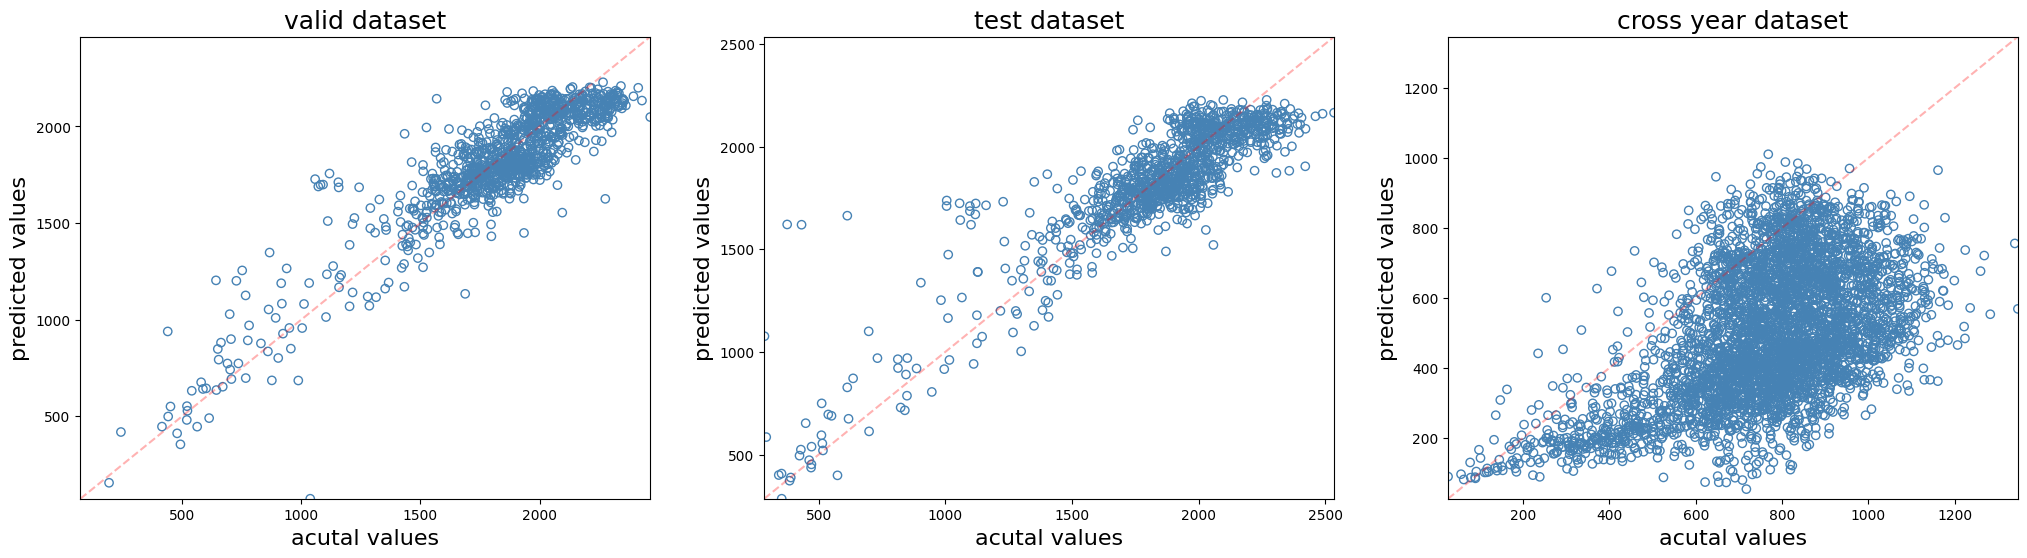

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 6))

valid_min = np.min([y_valid.min(), valid_pred.min()])
valid_max = np.max([y_valid.max(), valid_pred.max()])
axes[0].scatter(y_valid, valid_pred, facecolors="none", edgecolors="steelblue");
axes[0].set_xlim([valid_min, valid_max])
axes[0].set_ylim([valid_min, valid_max])
axes[0].set_title("valid dataset", fontsize=18);
axes[0].set_xlabel("acutal values", fontsize=16);
axes[0].set_ylabel("predicted values", fontsize=16);
axes[0].plot([valid_min, valid_max], [valid_min, valid_max], linestyle="--", color="red", alpha=0.3);

test_min = np.min([y_test.min(), test_pred.min()])
test_max = np.max([y_test.max(), test_pred.max()])
axes[1].scatter(y_test, test_pred, facecolors="none", edgecolors="steelblue");
axes[1].set_xlim([test_min, test_max])
axes[1].set_ylim([test_min, test_max])
axes[1].set_title("test dataset", fontsize=18);
axes[1].set_xlabel("acutal values", fontsize=16);
axes[1].set_ylabel("predicted values", fontsize=16);
axes[1].plot([test_min, test_max], [test_min, test_max], linestyle="--", color="red", alpha=0.3);

cross_year_min = np.min([y_testset.min(), cross_year_pred.min()])
cross_year_max = np.max([y_testset.max(), cross_year_pred.max()])
axes[2].scatter(y_testset, cross_year_pred, facecolors="none", edgecolors="steelblue");
axes[2].set_xlim([cross_year_min, cross_year_max])
axes[2].set_ylim([cross_year_min, cross_year_max])
axes[2].set_title("cross year dataset", fontsize=18);
axes[2].set_xlabel("acutal values", fontsize=16);
axes[2].set_ylabel("predicted values", fontsize=16);
axes[2].plot([cross_year_min, cross_year_max], [cross_year_min, cross_year_max], linestyle="--", color="red", alpha=0.3);

In [68]:
torch.save(model, "saved_model/bnn/cxv.pt")